In [797]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Initial idea of problem statement

In [527]:
sources = [[0.5,0.5], [0,0.5], [1,0.]]
radii = np.array([5, 3, 2])*30
uncertainty = np.repeat([0.1], 3)

In [528]:
source_profile = lambda i, x: np.exp(-np.sum(np.abs(radii[i]*(sources[i] - x)**2)))

In [529]:
ix_row, ix_col = np.indices((40,40)) / 40

In [530]:
field1, field2, field3 = map( 
            lambda k: np.array([[source_profile(k, np.array([ix_row[i,j], ix_col[i,j]])) for i in range(40)] 
                                for j in range(40)]),
            range(3))

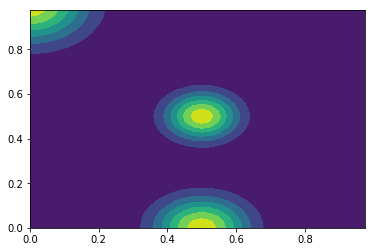

In [531]:
plt.contourf(ix_row, ix_col, (field1 + field2 + field3)/3)
plt.show()

## Define linear spline for pytorch

In [504]:
class LinearSpline(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, nknots):
        ctx.save_for_backward(input)
        input = input.detach().numpy()[0]   # Tensor => scalar. Assumes 1D input
        assert 0 <= input <= nknots - 1, "input must be between 0 and nknots-1."
        out = torch.zeros(nknots)
        start, rem = np.floor(input).astype('int'), input % 1
        if not np.isclose(start, nknots-1):
            out[max(start,0):min(start+2, nknots)] = torch.Tensor([1-rem, rem])
        else:
            out[nknots-1] = 1
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        input = input.detach().numpy()[0]
        grad_input = grad_output.clone()
        start, rem = np.floor(input).astype('int'), input % 1
        grad_input[start] *= -1
        grad_input[start+2:] *= 0
        grad_input[:start] *= 0
        return grad_input, None

In [505]:
# Instantiate pytorch object/function
linspl = LinearSpline.apply

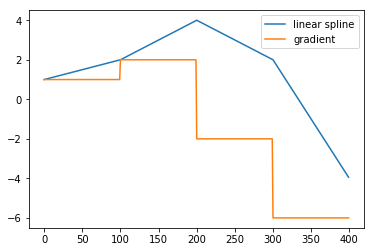

In [512]:
# Test Linear Spline
y = np.zeros(400)
g = np.zeros(400)

for i in range(400):
    inp = torch.Tensor([i / 100]).requires_grad_(True)
    tmp = torch.dot(linspl(inp, 5), torch.Tensor([1.0, 2, 4, 2, -4]))
    obj = tmp.sum()
    obj.backward()
    g[i] = inp.grad.numpy()
    y[i] = obj.detach().numpy()
    
plt.plot(y)
plt.plot(g)
plt.legend(["linear spline", "gradient"])
plt.show()

In [655]:
""" Make a vector-valued version
    yes - this can be done more efficiently, but req. more thought -- 
    see my pyalexutil package, and also for higher order splines.
"""


class LinearSpline(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, nknots):
        ctx.save_for_backward(input)
        N = input.nelement()
        input = input.detach().numpy()  # Tensor => scalar. Assumes 1D input
        out = torch.zeros(nknots, N)
        for j, x in enumerate(input):
            assert 0 <= x <= nknots - 1, "input must be between 0 and nknots-1."
            start, rem = np.floor(x).astype('int'), x % 1
            if not np.isclose(start, nknots-1):
                out[max(start,0):min(start+2, nknots), j] = torch.Tensor([1-rem, rem])
            else:
                out[nknots-1, j] = 1
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        input = input.detach().numpy()
        grad_input = grad_output.clone()
        for j, x in enumerate(input):
            start, rem = np.floor(x).astype('int'), input % 1
            grad_input[start, j] *= -1
            grad_input[start+2:, j] *= 0
            grad_input[:start, j] *= 0
        return grad_input, None
        
# Instantiate pytorch object/function
linspl = LinearSpline.apply

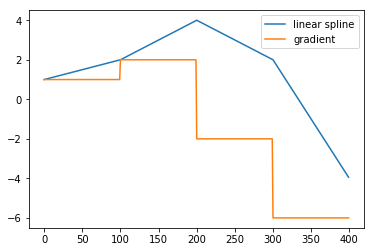

In [694]:
# Test Linear Spline
inp = (torch.linspace(0,399,400)/100).requires_grad_(True)
tmp = linspl(inp, 5)
obj_full = torch.sum(tmp * torch.Tensor([1.0, 2, 4, 2, -4]).reshape(5,1), dim=0)
obj = obj_full.sum()
obj.backward()

plt.plot(obj_full.detach().numpy())
plt.plot(inp.grad.numpy())
plt.legend(["linear spline", "gradient"])
plt.show()

## Problem definition

In [621]:
sources = [torch.Tensor(x) for x in [[0.55,0.6], [0,0.5], [1,0.]]]
radii = torch.Tensor([0.2, 0.1, 0.15])
uncertainty = torch.Tensor([0.1]).repeat(3)

In [957]:
def sample_radii(radii, uncertainty):
    return radii + torch.rand(len(radii)).type(uncertainty.dtype) * uncertainty

def plot_problem(sources, radii, ax):
    for s, r in zip(sources, radii):
        ax.add_artist(plt.Circle(s, r))

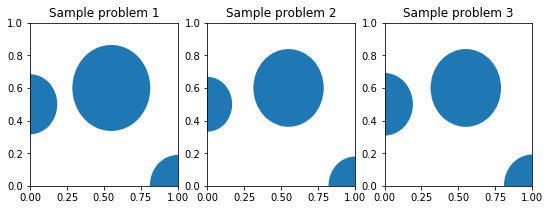

In [623]:
fig, axs = plt.subplots(1,3,figsize=(9,3))
for i in range(3):
    plot_problem(sources, sample_radii(radii, uncertainty), ax=axs[i])
    axs[i].set_title("Sample problem {:d}".format(i+1));
plt.show();

### Two different loss function for sources

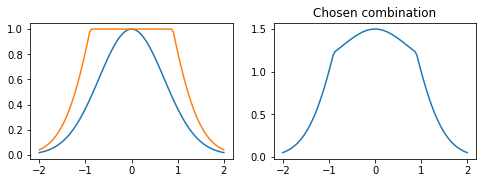

In [793]:
fig, axs = plt.subplots(1,2,figsize=(8, 2.5))
axs[0].plot(np.linspace(-2,2,100), np.exp(-np.linspace(-2,2,100)**2))
axs[0].plot(np.linspace(-2,2,100), np.exp(0.8-np.maximum(0.8, np.linspace(-2,2,100)**2)))

w1 = 0.5   # Gaussian/exp-quad kernel centered at source
w2 = 1.0   # "uniform disk" centered at source: this is a continuous version for C^1-differentiability
axs[1].plot(np.linspace(-2,2,100), w1*np.exp(-np.linspace(-2,2,100)**2) +
                                          w2*np.exp(0.8-np.maximum(0.8, np.linspace(-2,2,100)**2)))
axs[1].set_title("Chosen combination")
plt.show()

In [945]:
def objective(betas, radii, uncertainty, sources):
    
    # relative weights of intersection
    w1 = 0.5   # Gaussian/exp-quad kernel centered at source
    w2 = 1.0   # uniform disk centered at source
    
    # sample from piecewise linear path
    k = int(betas.nelement()/2)
    nsmp = 50
    n = nsmp * (k-1)
    inp = (torch.linspace(0,n-1,n)/nsmp).requires_grad_(True)
    interpolant = linspl(inp, k).type(betas.dtype)
    
    path = torch.cat(((betas[0,:] @ interpolant).reshape(1, n), 
                     (betas[1,:] @ interpolant).reshape(1, n)), dim=0)
    
    # simulate circles
    rs = sample_radii(radii, uncertainty)
    
    # calculate intersection of each (line, circle) combination
    obj = []
    for i in range(len(sources)):
        dist_sq = torch.sum((path - sources[i].reshape(2, 1))**2, dim=0)
        obj.append(w1*torch.exp(-dist_sq/(2*radii[i])).sum())
        obj.append((w2*torch.exp(0.8-torch.clamp(dist_sq, min=0.8))).sum())  # not differentiable
    
    # scalar objective
    obj = torch.stack(obj).sum()
    return obj

In [994]:
# inp = torch.rand(2, 4).requires_grad_(True)
# inp.data[:,0] = 0  # set start to (0,0)
# inp.data[:,-1] = 1  # set end to (1,1)
inp = torch.tensor([[0, 0.33, .67, 1],[0, 0.33, 0.67, 1]]).requires_grad_(True)
obj = objective(inp, radii, uncertainty, sources)
obj.backward()

In [995]:
optimizer = optim.Adam([inp], lr=0.001, weight_decay=0.1)

## Check gradient implementation is correct

In [996]:
optimizer.zero_grad()
loss = objective(inp, radii, uncertainty, sources)
loss.backward()
inp.grad

tensor([[ 33.2316,   3.2428, -29.9422, -38.0346],
        [ 28.1084,  31.9128, -32.5498, -51.7975]])

In [997]:
num_grad(lambda x: objective(x, radii.double(), uncertainty.double(), 
                             [x.double() for x in sources]), inp.detach().double())

array([[ 33.23158353,   3.24281473, -29.94220267, -38.03462505],
       [ 28.10844535,  31.91280484, -32.54978083, -51.79748541]])

## Optimize

In [992]:
for i in range(100):
    optimizer.zero_grad()
    loss = objective(inp, radii, uncertainty, sources)
    loss.backward()
    optimizer.step()
    inp.data[:,0] = 0  # project start to (0,0)
    inp.data[:,-1] = 1  # project end to (1,1)

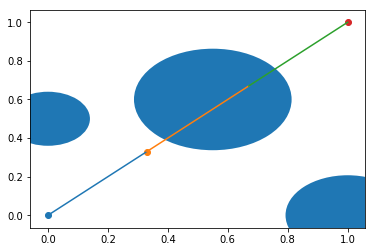

In [998]:
plot_problem(sources, sample_radii(radii, uncertainty), ax=plt.gca())
inpn = inp.detach().numpy()
for i in range(4):
    plt.scatter(*inpn[:,i])
for i in range(3):
    plt.plot(inpn[0,i:i+2], inpn[1,i:i+2])
plt.show()

## Numerical gradient (adapted from pyalexutil) for pytorch

In [966]:
def num_grad(fn, X, h=1e-8, verbose=True):
    """
    Calculate finite differences gradient of function fn evaluated at numpy
    array X. Not calculating central diff to improve speed and because some
    authors disagree about benefits.
    Most of the code here is really to deal with weird sizes of inputs or
    outputs. If scalar input and multi-dim output or vice versa, we return
    gradient in the shape of the multi-dim input or output. However, if both
    are multi-dimensional then we return as n_output vs n_input matrix
    where both input/outputs have been vectorised if necessary.
    """
    assert callable(fn), "fn is not a function"
#     assert isinstance(X, (np.ndarray, int, float)), "X should be a numpy array"
#     X = np.asarray(X)
    assert isinstance(h, float), "h should be of type float"

    shp = X.shape
    resize_x = X.ndimension() > 1
    rm_xdim = X.ndimension() == 0
    n = X.nelement()

    f_x = fn(X).double()
    if isinstance(f_x, (int, float)):
        im_f_shp = 0
        resize_y = False
    else:
        im_f_shp = np.asarray(f_x.shape)
        resize_y = not (f_x.ndimension() == 0 or (f_x.ndimension() <= 2 and np.any(f_x.shape == 1)))
        assert f_x.ndimension() <= 2, "image of fn is tensor. Not supported."

    m = np.prod(np.maximum(im_f_shp, 1)).astype(int)

    X = X.view(-1)
    g = np.ones((m, n))
    for ii in range(n):
        Xplus = X.clone().double()
        Xplus[ii] += h
        Xplus = Xplus.reshape(shp)
        grad = (fn(Xplus) - f_x) / h
        g[:, ii] = grad.detach().view(-1)

    if verbose and (resize_x and resize_y):
        warnings.warn("Returning gradient as matrix size n(fn output) x n(variables)")

    if rm_xdim and g.shape[1] == 1:
        g = g.ravel()
    elif resize_x and not np.any(im_f_shp > 1):
        g = g.reshape(shp)
    elif resize_y and not np.any(np.array(shp) > 1):
        g = g.reshape(im_f_shp)

    return g